# <p style="text-align: center;"> <b> Data Modeling </b> </p>


---

<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: left; background-color: #EDC0C7; font-family:newtimeroman; color: black; padding: 14px; line-height: 1; border-radius:10px"><b>Table of Contents ✍️</b></h3>
    
- [1. Problem Statement](#1)
    - [1.1 Problem description](#1.1)
    - [1.2 Purpose of solving the problem](#1.2)

- [2. Data Preparation](#2)
    - [2.1 Feature Engineering](#2.1)
    - [2.2 Split Data](#2.2)

- [3. Create, train and test models](#3)

<a class="anchor" id="1"></a>
## <div style="text-align: left; background-color:#EDC0C7; font-family:newtimeroman;color: black; padding: 14px; line-height: 1;border-radius:10px">1. Problem Statement </div>

<a class="anchor" id="1.1"></a>
## <span style='color:#2B9C15 '> 1.1 Problem description</span>

- Manga, a style of Japanese comic books and graphic novels, has achieved widespread popularity globally, contributing to a multibillion-dollar industry. The manga industry continues to grow rapidly, producing a diverse range of stories and genres.

- In this context, the problem is to predict the rating score of a manga based on its features. The goal is to develop a model that can estimate the rating of a manga series, providing valuable insights for manga enthusiasts and publishers.

<a class="anchor" id="1.2"></a>
## <span style='color:#2B9C15 '> 1.2 Purpose of solving the problem </span>

- **Enhanced Decision-Making**: By predicting the rating of a manga series, readers and enthusiasts can make more informed decisions about which manga to explore without having to read the entire series or spend time searching for reviews.

- **Market Insights**:  For publishers, distributors, and industry stakeholders, understanding the factors influencing a manga's rating provides valuable market insights. This knowledge can inform strategic decisions related to content creation, marketing, and audience targeting.

<a class="anchor" id="2"></a>
## <div style="text-align: left; background-color:#EDC0C7; font-family:newtimeroman;color: black; padding: 14px; line-height: 1;border-radius:10px">2. Data Preparation  </div>

👉 Before modelling, the data must be prepared. We will perform the following steps:
- Feature engineering
    - Feature selection
    - Convert categorical features to numerical
- Split data into training, validation, and test sets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # for literal_eval
import warnings
warnings.filterwarnings('ignore')

In [2]:
manga_df = pd.read_csv('../data/processed_comic.csv')
manga_df.head(3)

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Genres,Author,Recommended,Mixed Feelings,Not Recommended,Release date,Completed date
0,Berserk,9.47,331288,1,1,665300,122841,4,28,Publishing,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Miura Kentarou', 'Studio Gaga']",233,15,10,1989-08-25,2023-12-13
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,156368,2,26,256146,42864,24,96,Finished,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Araki Hirohiko'],120,7,1,2004-01-19,2011-04-19
2,Vagabond,9.24,136403,3,15,364891,40158,37,327,On Hiatus,"['Action', 'Adventure', 'Award Winning']","['Inoue Takehiko', 'Yoshikawa Eiji']",88,8,1,1998-09-03,2015-05-21


<a class="anchor" id="2.1"></a>
## <span style='color:#2B9C15 '> 2.1 Feature Engineering</span>

### 👉 Feature Selection

1. We will select meaningful features that are suitable for the problem and drop unnecessary features.

    - The `Ranked` of manga series is determined based on `Score` by arranging the manga series in descending order of `Score`. Therefore, when predicting the `Score` of a manga, we cannot use `Ranked` as a feature, so we will drop this feature.
    
    - Two features, `Title` and `Author`, have a large number of unique values and do not provide meaningful insights for analyzing or predicting the score of a manga series. Therefore, we will drop these two features.

    - `Status` is a feature that indicates what status a manga is in (Publishing, Finished, ...). This feature has no meaning in predicting the `Score` of a manga, so we will drop this feature as well.


In [3]:
new_df = manga_df.drop(columns=['Title', 'Author','Ranked', 'Status'])

2. Use the correlation matrix to consider the correlation of features with `Score` and drop features with low correlation (correlation magnitude < 0.2)

But first, we will convert the numerical features to right data types. In this case, we will convert `Release date` and `Completed date`

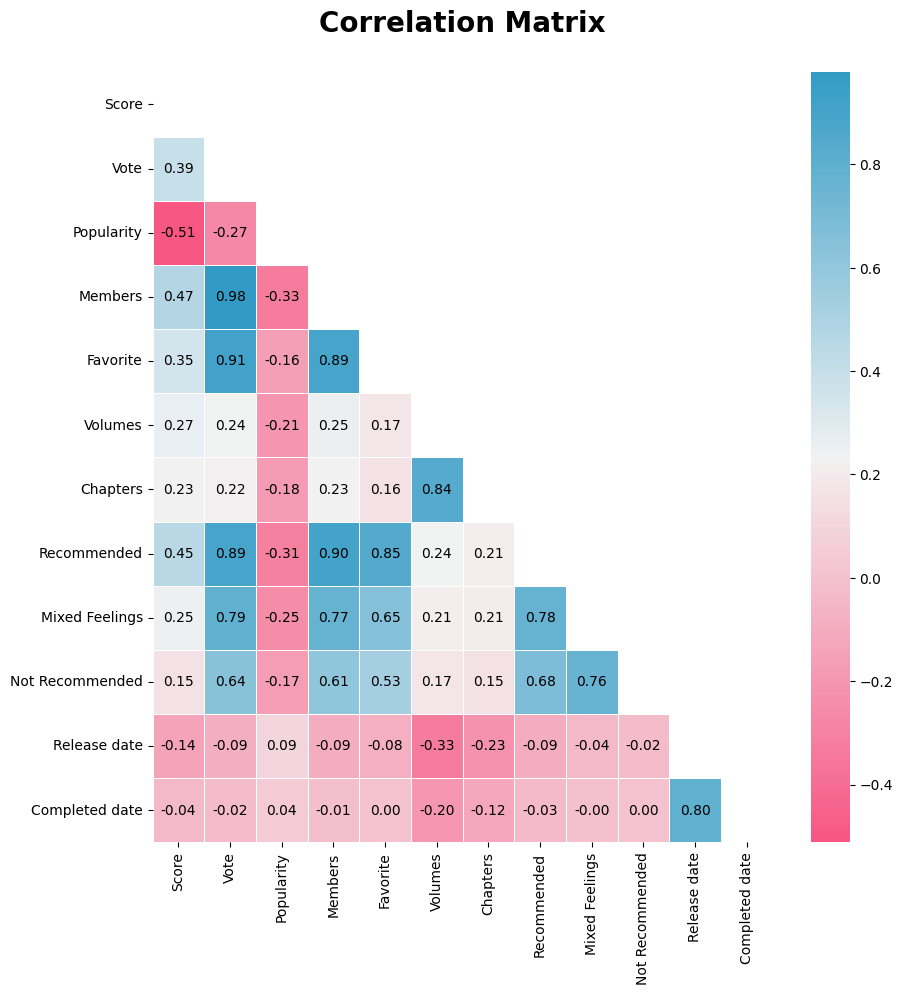

In [4]:
new_df[['Release date', 'Completed date']] = new_df[['Release date', 'Completed date']].apply(pd.to_datetime)

corr = new_df[['Score', 'Vote', 'Popularity', 'Members', 'Favorite','Volumes','Chapters','Recommended','Mixed Feelings','Not Recommended','Release date','Completed date']].corr()

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, ax=ax, mask=mask, cmap=cmap,fmt='.2f', linewidths=.5, linecolor='w',annot_kws=dict(color="k"))
plt.title('Correlation Matrix\n', fontsize=20, weight='bold')
plt.show()

`Not Recommended`, `Released date` and `Completed date` have low correlation with `Score` and will be dropped.

In [5]:
new_df = new_df.drop(columns=['Release date', 'Completed date','Not Recommended'])

### 👉 Convert categorical features to numerical features

The `Genres` feature represents a multi-label category, so we need to convert it to a list type first and then use multi-label binarizer to convert it to a numerical feature.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert 'Genres' into list of strings
new_df['Genres'] = new_df['Genres'].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(new_df['Genres']), columns=mlb.classes_, index=new_df.index)
new_df = pd.concat([new_df, genres_encoded], axis=1).drop(columns=['Genres'])
new_df.head(3)

,Score,Vote,Popularity,Members,Favorite,Volumes,Chapters,Recommended,Mixed Feelings,Action,...,Girls Love,Gourmet,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,9.47,331288,1,665300,122841,4,28,233,15,1,...,0,0,1,0,0,0,0,0,1,0
1,9.30,156368,26,256146,42864,24,96,120,7,1,...,0,0,0,1,0,0,0,0,1,0
2,9.24,136403,15,364891,40158,37,327,88,8,1,...,0,0,0,0,0,0,0,0,0,0


<a class="anchor" id="2.2"></a>
## <span style='color:#2B9C15 '> 2.2 Split data </span>
👉 In this step, we will follow these steps:

- Determine the target variable and the feature variables
- Split the data into training set, validation set and test set with the ratio of 80:10:10
- Scale the data using MinMaxScaler
    $$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [7]:
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler


features = ['Vote', 'Popularity', 'Members', 'Favorite', 'Volumes', 'Chapters',
            'Recommended', 'Mixed Feelings'] + list(mlb.classes_)
target = 'Score'

new_df = new_df[features + [target]]
train_data, test_data = train_test_split(new_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.33, random_state=42)

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4288, 27)
y_train shape: (4288,)
X_val shape: (1232, 27)
y_val shape: (1232,)
X_test shape: (607, 27)
y_test shape: (607,)


<a class="anchor" id="3"></a>
## <div style="text-align: left; background-color:#EDC0C7; font-family:newtimeroman;color: black; padding: 14px; line-height: 1;border-radius:10px">3. Create, train and test models </div>


## <span style='color:#2B9C15 '> 📕 Models </span>

To solve the problem, we will use the following machine learning models:

- Linear Regression
- XGBoost
- Random Forest

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_jobs=-1)
}


## <span style='color:#2B9C15 '> 📕 Metrics for evaluation models </span>
👉 The problem of predicting the `Score` of a manga series is a regression problem, so we will use metrics suitable for the regression problem to evaluate the model. Metrics used include:

- Mean Squared Error (MSE)
    $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2$$
- R2 Score
    $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y_i})^2}$$


## <span style='color:#2B9C15 '> 📕 Train models on training data </span>
**👉 We will train the models on the training data and evaluate the models on the validation data. Both MSE and R2 score will be stored to compare the performance of the models.**

In [9]:
train_scores = {}
val_scores = {}
mse_train = {}
mse_val = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    train_scores[model_name] = model.score(X_train, y_train)
    val_scores[model_name] = model.score(X_val, y_val)
    mse_train[model_name] = mean_squared_error(y_train, model.predict(X_train))
    mse_val[model_name] = mean_squared_error(y_val, model.predict(X_val))

**👉 Visualize the results of the models**

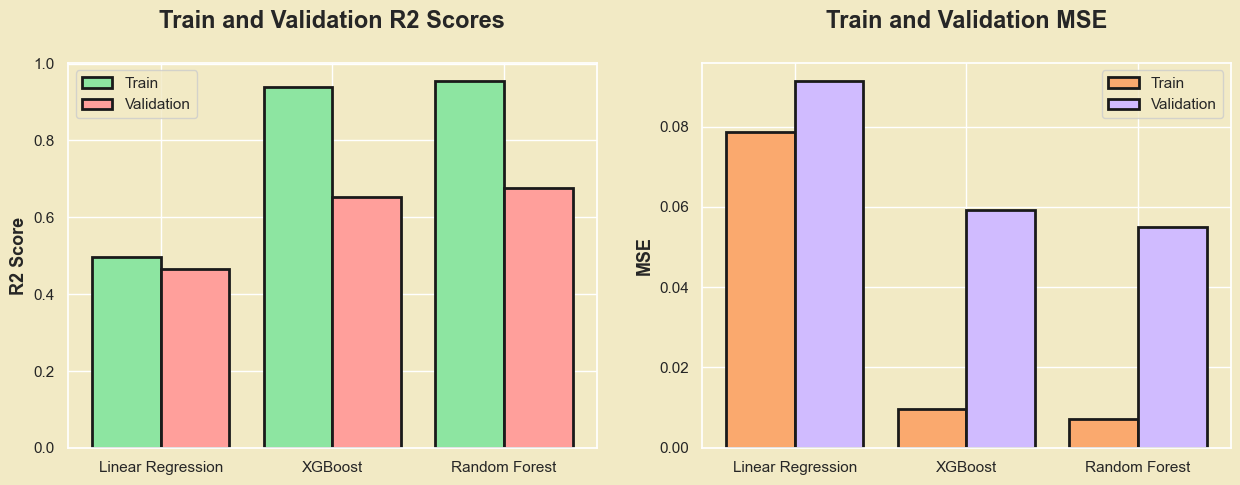

In [10]:
categories = list(train_scores.keys())
train_values = list(train_scores.values())
val_values = list(val_scores.values())
mse_train_values = list(mse_train.values())
mse_val_values = list(mse_val.values())

indices = np.arange(len(categories))
# sns.set_style("darkgrid")
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#'#8de5a1', '#ff9f9b'
ax[0].bar(indices - 0.2, train_values, width=0.4, label='Train', color='#8de5a1', linewidth=2, edgecolor='k')
ax[0].bar(indices + 0.2, val_values, width=0.4, label='Validation', color='#ff9f9b', linewidth=2, edgecolor='k')
ax[0].set_ylabel('R2 Score', fontsize=13, weight='bold')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('Train and Validation R2 Scores\n', fontsize=17, weight ='bold')
ax[0].legend()

ax[1].bar(indices - 0.2, mse_train_values, width=0.4, label='Train', color='#faa96e', linewidth=2, edgecolor='k')
ax[1].bar(indices + 0.2, mse_val_values, width=0.4, label='Validation', color='#d0bbff',  linewidth=2, edgecolor='k')
ax[1].set_xticks(indices)
ax[1].set_ylabel('MSE', fontsize=13, weight='bold')
ax[1].set_xticklabels(categories)
ax[1].set_title('Train and Validation MSE\n', fontsize=17, weight ='bold')
ax[1].legend()

plt.show()

### 📖 **COMMENTS:**

- Random Forest emerges as the algorithm with the best performance, showcasing the lowest MSE and the highest R2 score on both the training and test sets.
- XGBoost also demonstrates commendable results with high MSE and R2 scores, albeit slightly trailing behind Random Forest.
- Linear Regression yields the least favorable outcomes, displaying the highest MSE and the lowest R2 score. However, it exhibits a smaller disparity between the training and test sets compared to the other two algorithms.

**👉 Learning process of models**

- The three machine learning algorithms used in this study learn once on the entire dataset. Unlike deep learning algorithms, which learn gradually over each epoch, it is difficult to visualize the learning process of these models.

- We will address this challenge by using the learning curve of the scikit-learn library. This will allow us to visualize the learning process of these models by having them learn gradually over multiple training runs with increasing training set sizes

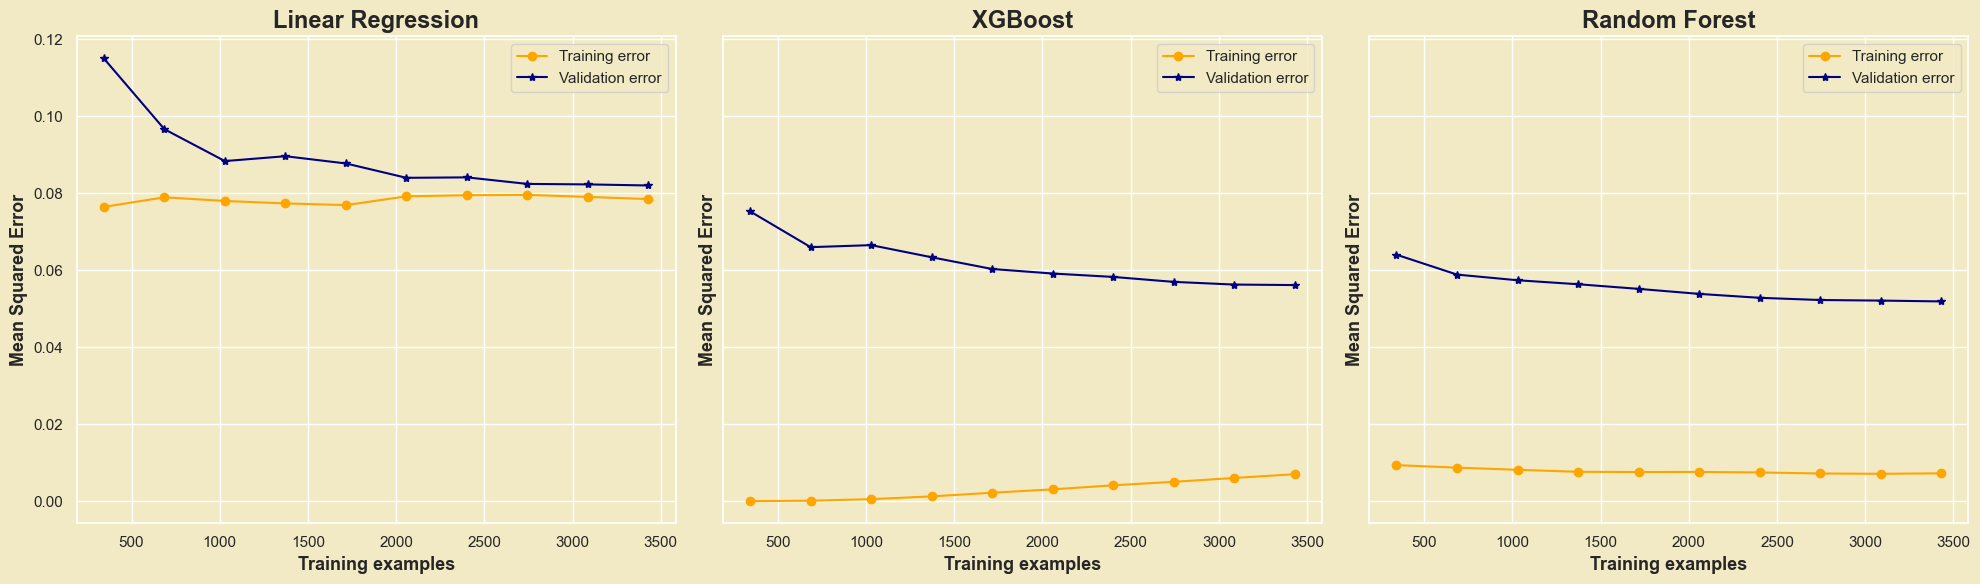

In [11]:
def plot_learning_curve(model, X, y, ax, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, label='Training error', color='orange', marker='o')
    ax.plot(train_sizes, val_scores_mean, label='Validation error', color='navy', marker='*')

    ax.set_title(title, fontsize=17,fontweight='bold')
    ax.set_xlabel('Training examples', fontsize=13, weight='bold')
    ax.set_ylabel('Mean Squared Error', fontsize=13, weight='bold')
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6),sharey=True)

for (model_name, model), ax in zip(models.items(), axes):
    plot_learning_curve(model, X_train, y_train, ax, model_name)

plt.tight_layout()
plt.show()

### 📖 **COMMENTS:**
**Learning Performance of Models**:

- Random Forest stands out as the top-performing model, achieving the best learning results with an MSE of approximately 0.01 on the training set and around 0.05 on the test set.

- XGBoost also demonstrates strong learning capabilities, with a slightly lower performance than the Random Forest model. It achieves an MSE of approximately 0.01 on the training set and around 0.06 on the test set.

- Linear Regression exhibits lower learning proficiency compared to the two models, with MSE values nearly equal between the training and test sets, around 0.08.

**Learning Process**:

- The MSE loss for all three models consistently decreases as the size of the training set increases, converging to a specific value.

- Linear Regression converges relatively quickly on the validation set despite starting with a higher initial MSE.

- Random Forest converges slowly, and there is a noticeable discrepancy between the training and validation sets.

- XGBoost starts with a nearly zero MSE but experiences an increase as the size of the training set grows.

## 👉 Fine-tune models on validation data

We will fine-tune the models on the validation data using bayesian search to find the best hyperparameters for the models. The hyperparameters we will tune are:

- **Linear Regression**
    - fit_intercept
    - positive
    - n_jobs
- **XGBoost**
    - n_estimators
    - max_depth
    - learning_rate
- **Random Forest**
    - n_estimators
    - max_depth
    - max_features


In [12]:
param_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'n_jobs': [-1, 1],
}
param_xgb = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
}
params_rf = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'max_features': (0.1, 1.0, 'uniform'),
}

np.int = int
opt_lr = BayesSearchCV(
    LinearRegression(),
    param_lr,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
opt_xgb = BayesSearchCV(
    XGBRegressor(n_jobs=-1),
    param_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

opt_rf = BayesSearchCV(
    RandomForestRegressor(n_jobs=-1),
    params_rf,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

opt_models = {
    'Linear Regression': opt_lr,
    'XGBoost': opt_xgb,
    'Random Forest': opt_rf
}

opt_lr.fit(X_val, y_val)
opt_xgb.fit(X_val, y_val)
opt_rf.fit(X_val, y_val)

for model_name, model in opt_models.items():
    print(f'{model_name}: {model.best_score_:.4f}')
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')
    print()

Linear Regression: 0.4525
fit_intercept: True
n_jobs: 1
positive: False

XGBoost: 0.6482
learning_rate: 0.180875564077442
max_depth: 2
n_estimators: 85

Random Forest: 0.6457
max_depth: 8
max_features: 0.8622514477983243
n_estimators: 100




## <span style='color:#2B9C15 '> 📕 Retrain models on training and validation data </span>


In [13]:
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

opt_lr.best_estimator_.fit(X_train_val, y_train_val)
opt_xgb.best_estimator_.fit(X_train_val, y_train_val)
opt_rf.best_estimator_.fit(X_train_val, y_train_val)  

RandomForestRegressor(max_depth=8, max_features=0.8622514477983243, n_jobs=-1)


## <span style='color:#2B9C15 '> 📕 Evaluate models on test data</span>

**👉 We still use both metrics to evaluate the models on the test set**

In [14]:
test_scores = {}
mse_test = {}
for model_name, model in opt_models.items():
    test_scores[model_name] = model.best_estimator_.score(X_test, y_test)
    mse_test[model_name] = mean_squared_error(y_test, model.predict(X_test))

**👉 Visualize the results of the models**

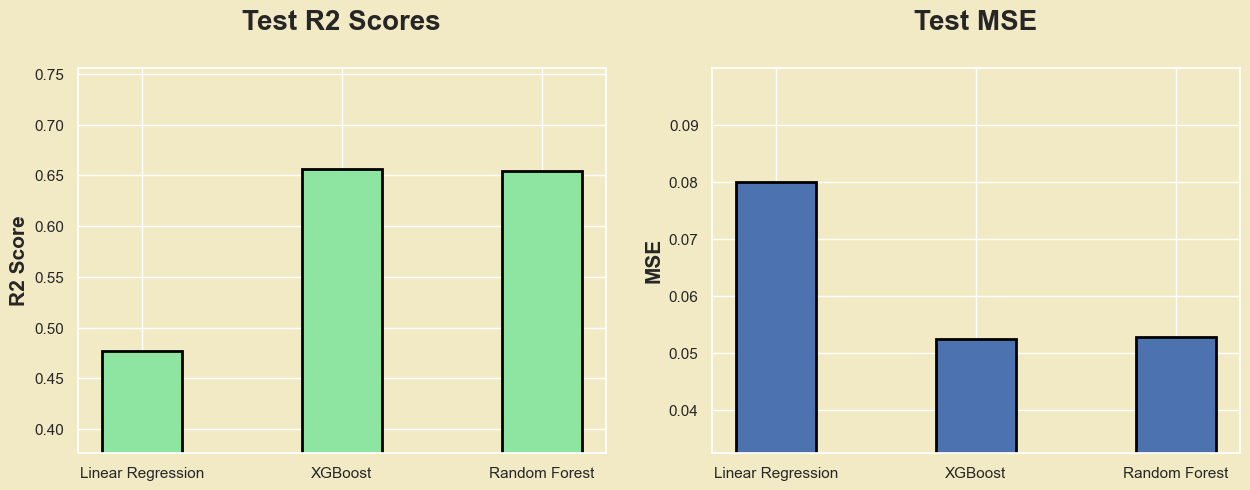

In [15]:
categories = list(test_scores.keys())
test_values = list(test_scores.values())
mse_test_values = list(mse_test.values())

indices = np.arange(len(categories))

sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(indices, test_values, width=0.4, linewidth=2, edgecolor = 'black', color='#8de5a1')
ax[0].set_ylabel('R2 Score', fontsize=15, weight='bold')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('Test R2 Scores\n', fontsize=20, weight ='bold')
ax[0].set_ylim(min(test_values) - 0.1, max(test_values) + 0.1)

ax[1].bar(indices, mse_test_values, width=0.4, linewidth=2, edgecolor = 'black')
ax[1].set_xticks(indices)
ax[1].set_ylabel('MSE', fontsize=15, weight='bold')
ax[1].set_xticklabels(categories)
ax[1].set_title('Test MSE\n', fontsize=20, weight ='bold')
ax[1].set_ylim(min(mse_test_values) - 0.02, max(mse_test_values) + 0.02)

plt.show()

### 📖 **COMMENTS:**

- In the training process on both the training and validation sets, Random Forest continues to exhibit the best performance, with the lowest MSE and the highest R2 score on the test set, followed by XGBoost. Linear Regression remains the least performing model.

- All three models demonstrate acceptable accuracy and errors, with MSE below 0.1 and R2 scores exceeding 0.5. In the future, with additional data and improved data processing techniques, there is potential to enhance the performance of these models

**👉 Let's see 10 random samples from the test set and compare the actual `Score` with the predicted `Score` of the models**

In [16]:
df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': opt_lr.best_estimator_.predict(X_test),
    'XGBoost': opt_xgb.best_estimator_.predict(X_test),
    'Random Forest': opt_rf.best_estimator_.predict(X_test)
})
df.sample(10)

,Actual,Linear Regression,XGBoost,Random Forest
809,7.86,7.782504,7.890158,7.755463
2753,7.37,7.001527,7.054526,7.084658
3618,7.23,7.406665,7.227184,7.200939
4573,7.10,7.016829,7.071902,7.105528
4410,7.12,7.587996,7.498826,7.442489
718,7.90,7.485547,7.860363,7.955524
4231,7.15,7.247267,7.182246,7.158735
599,7.97,7.503689,7.535668,7.564082
620,7.95,7.407444,7.217761,7.150039
2215,7.46,7.234094,7.091477,7.105028


<div style="text-align: left; background-color:#EDC0C7; font-family:Arial; color:black; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px;border-style: solid;border-color: black;">END</div>